In [28]:
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)
df = pd.read_csv("meta.csv")
# Filter to just shapefiles that have the CRS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,Pixel_ER
0,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif,0.600000
1,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_19FEB2010.shp,MaxarImagery/HighFreq/Tasman/MoutereRiver/Imagery/Stack/MoutereRiver_19FEB2010.tif,0.600000
2,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_31JAN1980.shp,Retrolens/Tasman/MoutereRiver/Stack/MoutereRiver_31JAN1980_mosaic.jp2,1.399795
3,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_10AUG2003.shp,MaxarImagery/HighFreq/Tasman/MoutereRiver/Imagery/Stack/MoutereRiver_10AUG2003.tif,0.600000
4,Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_19APR2017.shp,MaxarImagery/HighFreq/Tasman/MoutereRiver/Imagery/Stack/MoutereRiver_19APR2017.tif,0.500000
...,...,...,...
1454,Retrolens/HawkesBay/MohakaRiver_East/Shorelines/MohakaRiver_East_16JAN2003.shp,Retrolens/HawkesBay/MohakaRiver_East/Stack/MohakaRiver_East_16JAN2003_mosaic.jp2,1.129062
1455,Retrolens/HawkesBay/MohakaRiver_East/Shorelines/MohakaRiver_East_4MAR1943.shp,Retrolens/HawkesBay/MohakaRiver_East/Stack/MohakaRiver_East_4MAR1943_mosaic.jp2,0.488775
1456,Retrolens/HawkesBay/Nuhaka/Shorelines/Nuhaka_13SEP1962.shp,Retrolens/HawkesBay/Nuhaka/Stack/Nuhaka_13SEP1962_mosaic.jp2,0.449296
1457,Retrolens/HawkesBay/Nuhaka/Shorelines/Nuhaka_16JAN2003.shp,Retrolens/HawkesBay/Nuhaka/Stack/Nuhaka_16JAN2003_mosaic.jp2,1.134699


Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [13]:
def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"ressci201900060-RNC2-Coastal/{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        print(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 50:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if scale < 20000:
        return 2.09
    elif scale < 30000:
        return 2.43
    else:
        return 2.9


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

for i, row in tqdm(df.iterrows(), total=len(df)):
    filename = row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    shapefile = gpd.read_file(filename)
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        continue
    if "Source" not in shapefile.columns:
        print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            source = "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            source = "MAX"
        else:
            source = "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            print(f"{filename} has no sources")
            if filename.startswith("MaxarImagery/HighFreq"):
                sources = ["MAX"]
            else:
                sources = ["Unknown"]
        if len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
        source = sources[0]

    if source != "MAX" and filename.startswith("MaxarImagery"):
        print(f"{filename} doesn't have MAX source, overriding")
        source = "MAX"

    if source == "MAX":
        photoscale = "VHR"
        Georef_ER = 1.17
    elif source == "LDS":
        photoscale = "VHR"
        Georef_ER = 0
    else:
        if "DSASdate" in shapefile.columns:
            shapefile["DSASDate"] = shapefile.DSASdate
        dates = shapefile.DSASDate.unique()
        if len(dates) > 1:
            print(f"{filename} has ambiguous DSASDates: {dates}")
        if len(dates) == 0 or not dates[0]:
            print(f"{filename} has no DSASDate")
            DSASDate = year
        else:
            DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")
        try:
            photoscale = get_scale(filename, DSASDate, year)
        except Exception as e:
            print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
            continue
        Georef_ER = get_Georef_ER(photoscale)

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    Eg = Georef_ER
    for i, row in shapefile.iterrows():
        if row.CPS not in CPS_error_lookup:
            print(f"{row.CPS} not in CPS_error_lookup, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    # display(shapefile)
    # To write results back to file:
    shapefile.to_file(filename)

  0%|          | 0/1135 [00:00<?, ?it/s]

9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
Ambiguous scales found for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv for date 11/10/1950: Scale
17400    6
16700    1
Name: count, dtype: int64. Taking 17400
9 not in CPS_error_lookup, skipping
Matching 1980 to 30/01/1980 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Tasman/RuataniwhaInlet/RuataniwhaInlet.csv
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_09APR1965.shp has ambiguous DSASDates: ['09/04/1965' '9/04/1965']
9 not in CPS_error_lookup, skipping
9 not in CPS_error_lookup, skipping
Retrolens/Tasman/Totaranui/Shorelines/Totaranui_08FEB1952.shp has ambiguous DSASDates: ['08/02/1952' '8/02/1952']
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp has ambiguous sources: ['RL' None]
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver

In [15]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:26: TqdmWarning: Iterable length 1898 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
100%|███████████████████████████████████████| 1898/1898 [00:30<00:00, 62.21it/s]


In [31]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count    7263.000000
mean        2.983476
std         2.004677
min         0.441475
25%         1.599937
50%         2.452305
75%         3.240205
max         9.772838
Name: Total_UNCY, dtype: float64

In [17]:
df

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,filename,Dig_ER,DATE_,DSASdate,Length,Date_,Scale_1,SN,DSASDate_1,UNCY,OBJECTID,SourceFile,Year_,Month_,Day_,Date2,Shape_Leng,Shape_Le_1,DSAS_NZDAT,geometry
0,0,HawkesBay,Mahanga,2005-08-31,31/08/2005,AF,1000,edge of veg,MAX,2,1,VHR,1.17,0.6,1.503928,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.88792 -39.01518, 177.88782 -39.01512, 177.88775 -39.01510, 177.88768 -39.01509, 177.88761 -39.01507, 177.88753..."
1,0,HawkesBay,Mahanga,2005-08-31,31/08/2005,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.6,1.633952,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_31AUG2005.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.89780 -39.07104, 177.89791 -39.07116, 177.89799 -39.07149, 177.89800 -39.07161, 177.89804 -39.07179, 177.89810..."
2,0,HawkesBay,Mahanga,2011-01-29,29/01/2011,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.5,1.599937,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_29JAN2011.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.88811 -39.01504, 177.88800 -39.01505, 177.88785 -39.01505, 177.88774 -39.01504, 177.88760 -39.01498, 177.88755..."
3,0,HawkesBay,Mahanga,2011-01-29,29/01/2011,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.5,1.599937,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_29JAN2011.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.89765 -39.07099, 177.89784 -39.07114, 177.89787 -39.07121, 177.89792 -39.07134, 177.89795 -39.07147, 177.89797..."
4,0,HawkesBay,Mahanga,2015-12-25,25/12/2015,AF,1000,edge of veg,MAX,3,1,VHR,1.17,0.5,1.599937,MaxarImagery/HighFreq/HawkesBay/Mahanga/Shorelines/Mahanga_25DEC2015.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (177.90875 -39.07788, 177.90871 -39.07785, 177.90865 -39.07782, 177.90864 -39.07779, 177.90859 -39.07776, 177.90861..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12368,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,1,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.90022 -41.02754, 174.90004 -41.02764, 174.89994 -41.02771, 174.89991 -41.02775, 174.89982 -41.02778, 174.89971..."
12369,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,7,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.89785 -41.02915, 174.89700 -41.02926, 174.89644 -41.02914, 174.89627 -41.02918, 174.89603 -41.02926, 174.89548..."
12370,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,1,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.89520 -41.02952, 174.89498 -41.02953, 174.89480 -41.02954, 174.89458 -41.02954, 174.89414 -41.02953, 174.89376..."
12371,0,Wellington,PukeruaBay,1980-09-20,20/09/1980,MD,1000,None,RLN,3,1,None,NaN,NaN,NaN,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_20SEP1980.shp,NaN,None,None,NaN,None,NaN,None,None,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,"LINESTRING (174.88652 -41.02812, 174.88628 -41.02818, 174.88605 -41.02830, 174.88597 -41.02846, 174.88584 -41.02864, 174.88559..."


In [18]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    7263
True     5110
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

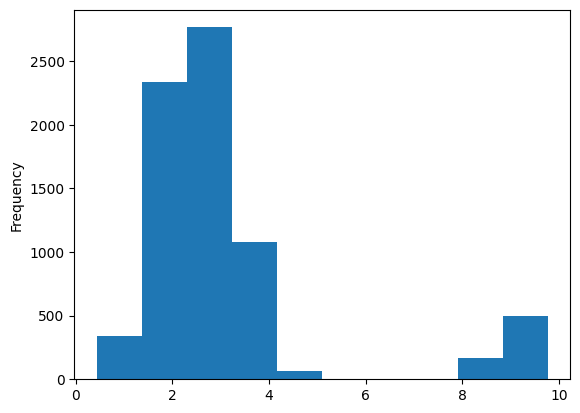

In [19]:
df.Total_UNCY.plot.hist()

In [20]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                                         9.665489
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                                         9.644290
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                                          9.207819
Retrolens/HawkesBay/BayView/Shorelines/Bayview_17DEC1996.shp                                              9.177801
Retrolens/HawkesBay/MohakaRiver/Shorelines/MohakaRiver_12DEC1996.shp                                      9.175944
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                                         9.174151
Retrolens/Bay of Plenty/PapateaBay/Shorelines/PapateaBay_31MAR1960.shp                                    9.172843
Retrolens/HawkesBay/Nuhaka/Shorelines/Nuhaka_16JAN2003.shp                                                9.137048
Retrolens/HawkesBay/Tahaenui/Shorelines/Tahaenui_16JAN2003.shp         

In [21]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RLS    6.236461
RS     5.819791
RL     3.524779
RLN    3.308664
AF     2.770902
MD     2.588462
Rl     2.265828
MAX    2.158562
Max    1.616393
LDS    1.071542
CRI         NaN
PLE         NaN
Name: Total_UNCY, dtype: float64

In [33]:
df.Photoscale.value_counts()

Photoscale
VHR      2818
25000     716
16000     398
50000     313
17400     310
         ... 
45000       2
11600       2
18800       2
19600       1
18850       1
Name: count, Length: 78, dtype: int64

In [32]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
NaN     4929
1.17    2762
2.09    1761
2.43    1756
2.90    1109
0.00      56
Name: count, dtype: int64

In [30]:
df[(df.Source == "LDS") & ~df.Total_UNCY.isna()]

AttributeError: 'DataFrame' object has no attribute 'Source'